In [1]:
%matplotlib inline

In [4]:
import os
import json

import numpy as np
from scipy.ndimage import median_filter
import pylab as plt

import h5py
import cv2

from pprint import pprint
from glob import glob

import dask.array as da

import astra
import time
import numexpr as ne

In [5]:
from scipy.ndimage import median_filter

In [6]:
from tomopy.misc.corr import remove_ring

In [7]:
plt.viridis();

In [8]:
def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = size / 200     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = unicode(index or '?')

In [10]:
import errno    
import os


def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

In [11]:
# file_id = 'a789cd0f-f718-4ff2-9f89-01b015cd13c8'
# file_id = '8eee41d5-8c4e-49d8-a496-898200bed0d5'
# file_id = '5e233c53-2925-4774-b680-0d71f73eb8e1'
# file_id = 'f3e80ec9-324f-41bb-a93e-605bcbbcde98'
# file_id = '1032b444-3eeb-4b30-90c6-64f571dc25de'
# file_id = '7efa3f65-ec22-4981-a0dd-40797b15db69'
# file_id = 'e6fe4ea1-79ef-47bc-bc06-d1d62c4fa03d'
# file_id = 'c69910c3-df64-4957-9d06-b1655957e174'  # hand_113_17_40
# file_id = '294e75e0-b24c-4c22-8bfa-79fb9d98bcfa'  # hand_113_15_40
# file_id = 'b564953e-302e-43c5-96cd-3172f8ab94b2'
# file_id = '6953bebf-4c50-4da1-8fa5-a6987a6ca36c'
file_id= '6cdba5b0-f172-4d12-bd21-ea4352109583'
data_dir = '/diskmnt/fast/makov/robotom/'
tmp_dir = os.path.join(data_dir, file_id)
mkdir_p(tmp_dir)
data_file = os.path.join(data_dir, file_id+'.h5')
if not os.path.isfile(data_file):
    !wget  http://10.0.7.153:5006/storage/experiments/{file_id}/hdf5 -O {data_file}

--2017-01-31 15:25:37--  http://10.0.7.153:5006/storage/experiments/6cdba5b0-f172-4d12-bd21-ea4352109583/hdf5
Connecting to 10.0.7.153:5006... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4914128701 (4,6G) [application/x-hdf5]
Saving to: ‘/diskmnt/fast/makov/robotom/6cdba5b0-f172-4d12-bd21-ea4352109583.h5’

100%[====================================>] 4 914 128 701  473MB/s   in 6,2s   

2017-01-31 15:25:44 (756 MB/s) - ‘/diskmnt/fast/makov/robotom/6cdba5b0-f172-4d12-bd21-ea4352109583.h5’ saved [4914128701/4914128701]



In [12]:
# with h5py.File(data_file) as hf:
#     d = hf['data'][u'50'].value.astype('float32')
#     e = hf['empty'][u'10'].value.astype('float32')
#     dk = hf['dark'][u'0'].value.astype('float32')

In [13]:
# r = (d-dk)/(e-dk)
# plt.figure(figsize=(10,10))
# plt.imshow(r[1500:2000, 1000:2000])
# plt.colorbar(orientation='horizontal')

In [14]:
def check_data(data_file):
    """
    lad data and show intesity
    """
    frame_count = len(h5py.File(data_file,'r')['data'])
    print frame_count
    s=[]
    with h5py.File(data_file,'r') as h5f:
         for k,v in log_progress(h5f['data'].items()):
    #         x = v.value
            s.append([int(k), np.sum(np.log(v.value+1))])
            del v
            
    y = [d[1] for d in s]
    x = [d[0] for d in s]
    plt.figure(figsize=(7,5))
    plt.plot(x,y,'o')
    # plt.gca().set_ylim([np.min(y)*0.9,np.max(y)*1.05])
    plt.grid(True)
    plt.ylabel('Frame number')
    plt.ylabel('Total intensity')
    plt.show()

409


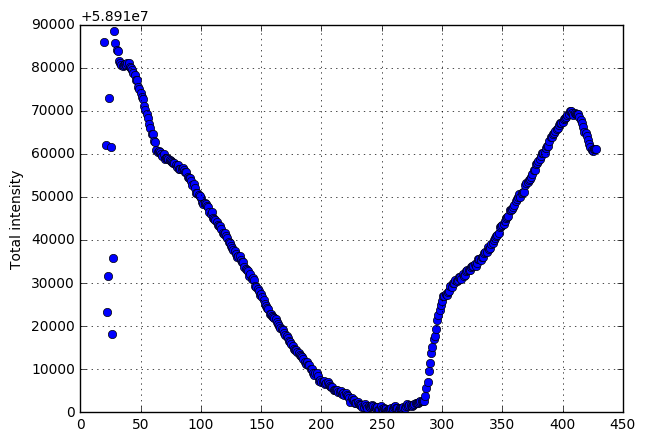

In [16]:
check_data(data_file)

In [13]:
def get_shape(data_file):
    if os.path.exists(data_file+'.size'):
        res = np.loadtxt(data_file+'.size').astype('uint16')
        if res.ndim>0:
            return tuple(res)
        else:
            return (res,)
    else:
        return None
        
def load_create_mm(data_file, shape, dtype, force_create=False):   
    if force_create:
        print('Force create')
    elif os.path.exists(data_file): 
        if (shape is None) and (get_shape(data_file) is not None):
            print(get_shape(data_file))
            res = np.memmap(data_file, dtype=dtype, mode='r+', shape=get_shape(data_file))
            print('Loading existing file: {}'.format(data_file))
            return (res, True) 
        elif (np.array(shape)==get_shape(data_file)).all(): 
            res = np.memmap(data_file, dtype=dtype, mode='r+', shape=shape)
            print('Loading existing file: {}'.format(data_file))
            return (res, True)
        else:
            print('Shape missmatch.')
    
    print('Creating new file: {}'.format(data_file))
    res = np.memmap(data_file, dtype=dtype, mode='w+', shape=shape)
    np.savetxt(data_file+'.size', res.shape,fmt='%5u')
    return(res, False)
    

def get_frame_group(data_file, group_name, mmap_file_dir):
    with h5py.File(data_file,'r') as h5f:
        images_count = len(h5f[group_name])
        images = None
        file_number = 0
        angles = None
        for k,v in log_progress(h5f[group_name].items()):
            if images is None:
                mm_shape = (images_count, v.shape[1], v.shape[0])
                images, is_images_exists = load_create_mm(
                    os.path.join(mmap_file_dir,'group_'+group_name+'.tmp'),
                    shape=mm_shape, dtype='float32')
                                        
            if angles is None:
                angles, is_angles_exists = load_create_mm(
                        os.path.join(mmap_file_dir,'group_'+group_name+'_angles.tmp'),
                        shape=(images_count,), dtype='float32')
            if is_images_exists and is_angles_exists:
                print('Images and angles in group {} found. Skip it'.format(group_name))
                break
            attributes = json.loads(v.attrs.items()[0][1])[0]
            exposure = attributes['frame']['image_data']['exposure']
            angles[file_number] = attributes['frame']['object']['angle position']
            tmp_image = np.flipud(v.value.astype('float32').swapaxes(0,1))
#             tmp_image = median_filter(tmp_image,3)
            tmp_image = cv2.medianBlur(tmp_image,3)
            images[file_number] = tmp_image / exposure
            file_number = file_number + 1
    
    return images, angles

In [16]:
empty_images, _ = get_frame_group(data_file, 'empty', tmp_dir)
dark_images, _ = get_frame_group(data_file, 'dark', tmp_dir)
# считаем среднее значение
empty_image = empty_images.sum(axis=0)/len(empty_images)
dark_image = dark_images.sum(axis=0)/len(dark_images)

empty_beam = empty_image-dark_image
mask = empty_beam > 0.01

# Загружаем кадры с даннымии
#TODO: добавить поддержку, когда много кадров на одном угле
data_images, data_angles = get_frame_group(data_file, 'data', tmp_dir)

#TODO: Fix it hack
data_indexes = (data_angles-data_angles.min())<181
data_images_180, _  = load_create_mm(os.path.join(tmp_dir,'data_images_180.tmp'),
                        shape=(data_indexes.sum(),
                               data_images.shape[1],
                               data_images.shape[2]),dtype='float32')
            
data_angles_180, _ = load_create_mm(
                        os.path.join(tmp_dir,'data_angles_180.tmp'),
                        shape=(data_indexes.sum(),), dtype='float32')

pos = 0
for edi, di in enumerate(data_indexes):    
    if di:
        data_images_180[pos] = data_images[edi]-dark_image
        data_angles_180[pos] = data_angles[edi]
        pos = pos+1

del data_images
del data_angles
del empty_images
del dark_images
del dark_image

Loading existing file: /diskmnt/fast/makov/robotom/6953bebf-4c50-4da1-8fa5-a6987a6ca36c/group_empty.tmp
Loading existing file: /diskmnt/fast/makov/robotom/6953bebf-4c50-4da1-8fa5-a6987a6ca36c/group_empty_angles.tmp
Images and angles in group empty found. Skip it
Loading existing file: /diskmnt/fast/makov/robotom/6953bebf-4c50-4da1-8fa5-a6987a6ca36c/group_dark.tmp
Loading existing file: /diskmnt/fast/makov/robotom/6953bebf-4c50-4da1-8fa5-a6987a6ca36c/group_dark_angles.tmp
Images and angles in group dark found. Skip it
Loading existing file: /diskmnt/fast/makov/robotom/6953bebf-4c50-4da1-8fa5-a6987a6ca36c/group_data.tmp
Loading existing file: /diskmnt/fast/makov/robotom/6953bebf-4c50-4da1-8fa5-a6987a6ca36c/group_data_angles.tmp
Images and angles in group data found. Skip it
Loading existing file: /diskmnt/fast/makov/robotom/6953bebf-4c50-4da1-8fa5-a6987a6ca36c/data_images_180.tmp
Loading existing file: /diskmnt/fast/makov/robotom/6953bebf-4c50-4da1-8fa5-a6987a6ca36c/data_angles_180.tmp


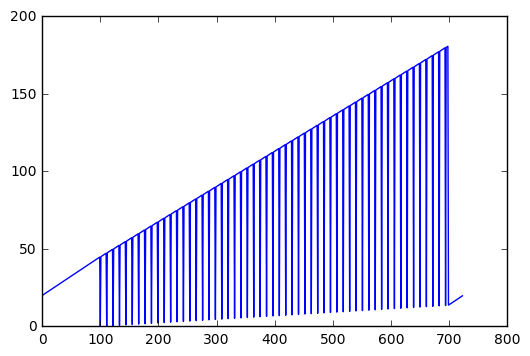

In [17]:
plt.plot(data_angles_180-data_angles_180.min())

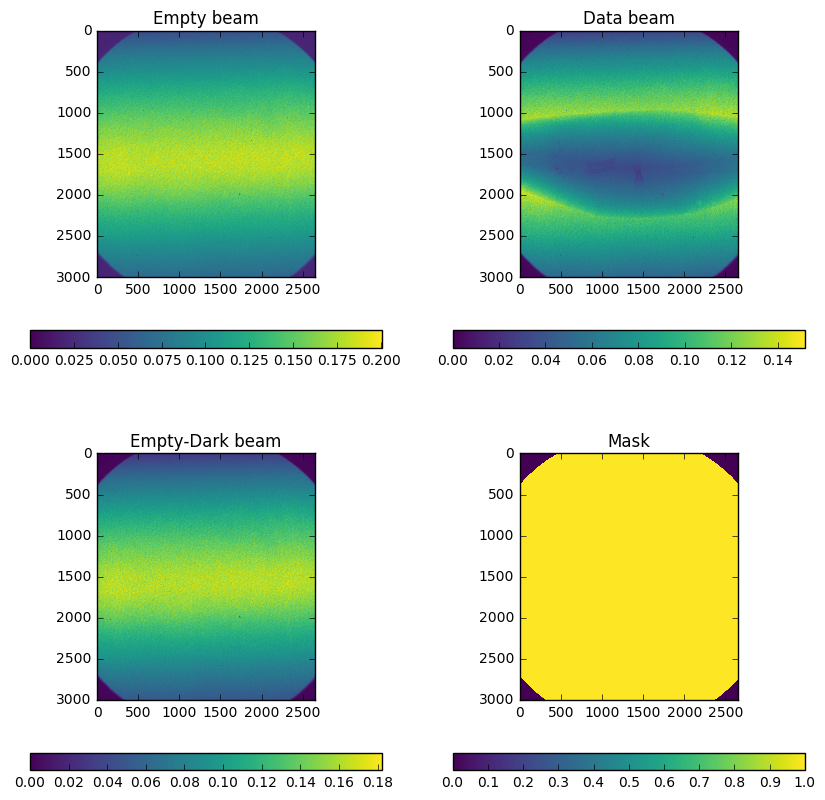

In [18]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(empty_image, vmin=0)
plt.colorbar(orientation='horizontal')
plt.title('Empty beam')

plt.subplot(222)
plt.imshow(data_images_180[0], vmin=0)
plt.colorbar(orientation='horizontal')
plt.title('Data beam')


plt.subplot(223)
plt.imshow(empty_beam, vmin=0)
plt.colorbar(orientation='horizontal')
plt.title('Empty-Dark beam')


plt.subplot(224)
plt.imshow(mask)
plt.colorbar(orientation='horizontal')
plt.title('Mask')
#TODO: Check thresshold automaticaly
# plt.plot([sum(empty_beam > i) for i in np.arange(100)])

In [19]:
# # try find automatic threshold for mask
# x_range = np.arange(0,0.2,0.01)
# plt.plot(x_range, [(empty_beam > x).sum().astype('float32')/np.prod(empty_beam.shape) for x in x_range])

In [20]:
def crop_mask(mask, up, bottom, left, right):
    threshold = 100
    mask_x_profile = mask.sum(axis=1)
    mask_x_min = np.argwhere(mask_x_profile>threshold).min()+up # up border
    mask_x_max = np.argwhere(mask_x_profile>threshold).max()-bottom # bottom border

    mask_y_profile = mask.sum(axis=0)
    mask_y_min = np.argwhere(mask_y_profile>threshold).min()+left # left border
    mask_y_max = np.argwhere(mask_y_profile>threshold).max()-right # right border
    return  mask_x_min, mask_x_max, mask_y_min, mask_y_max

Force create
Creating new file: /diskmnt/fast/makov/robotom/6953bebf-4c50-4da1-8fa5-a6987a6ca36c/data_images_masked.tmp
Force create
Creating new file: /diskmnt/fast/makov/robotom/6953bebf-4c50-4da1-8fa5-a6987a6ca36c/empty_images_masked.tmp


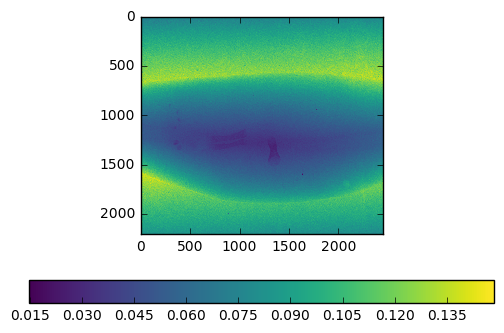

In [21]:
mask_x_min, mask_x_max, mask_y_min, mask_y_max = crop_mask(mask, 400, 400, 100, 100)

mask_new = np.copy(mask[mask_x_min:mask_x_max,mask_y_min:mask_y_max])
# empty_beam = empty_beam[mask_x_min:mask_x_max,mask_y_min:mask_y_max]
## FIX IT
# data_images_croped = data_images_croped[:, mask_x_min:mask_x_max,mask_y_min:mask_y_max]

data_images_masked, _ = load_create_mm(os.path.join(tmp_dir,'data_images_masked.tmp'),
                                   shape = (data_angles_180.shape[0],
                                           mask_new.shape[0], mask_new.shape[1]), dtype='float32',
                                   force_create=True)

empty_masked, _ = load_create_mm(os.path.join(tmp_dir,'empty_images_masked.tmp'),
                                   shape = (mask_new.shape[0], mask_new.shape[1]), dtype='float32',
                                   force_create=True)

empty_masked[:] = empty_beam[mask_x_min:mask_x_max,mask_y_min:mask_y_max]


plt.figure()
plt.imshow(data_images_180[0, mask_x_min:mask_x_max,mask_y_min:mask_y_max])
plt.colorbar(orientation='horizontal')

for di in range(data_images_masked.shape[0]):
    data_images_masked[di] = data_images_180[di, mask_x_min:mask_x_max,mask_y_min:mask_y_max]

del empty_beam
del data_images_180

In [25]:
def group_data(data_images,data_angles,  mmap_file_dir):
    uniq_angles,_ = load_create_mm(
        os.path.join(mmap_file_dir,'uniq_angles.tmp'),
        shape=(len(list(set(data_angles))),),
        dtype='float32',force_create=True)
    uniq_angles[:] = list(set(data_angles))
    
    uniq_data_images,_ = load_create_mm(
        os.path.join(mmap_file_dir,'uniq_data_images.tmp'),
        shape=(len(uniq_angles), data_images.shape[1], data_images.shape[2]),
        dtype='float32',force_create=True)

    for ua_id, ua in enumerate(uniq_angles):
        indexes = np.argwhere(data_angles==uniq_angles[ua_id])
        if len(indexes)>1:
            tmp_images = data_images[indexes]
            tmp_images = np.squeeze(tmp_images)
            mean_image = np.mean(tmp_images, axis=0)
            uniq_data_images[ua_id] = mean_image
        else:
            uniq_data_images[ua_id]=data_images[indexes]
    return uniq_data_images, uniq_angles

uniq_data_images, uniq_angles = group_data(data_images_masked, data_angles_180, tmp_dir)
del data_images_masked, data_angles_180

Force create
Creating new file: /diskmnt/fast/makov/robotom/6953bebf-4c50-4da1-8fa5-a6987a6ca36c/uniq_angles.tmp
Force create
Creating new file: /diskmnt/fast/makov/robotom/6953bebf-4c50-4da1-8fa5-a6987a6ca36c/uniq_data_images.tmp


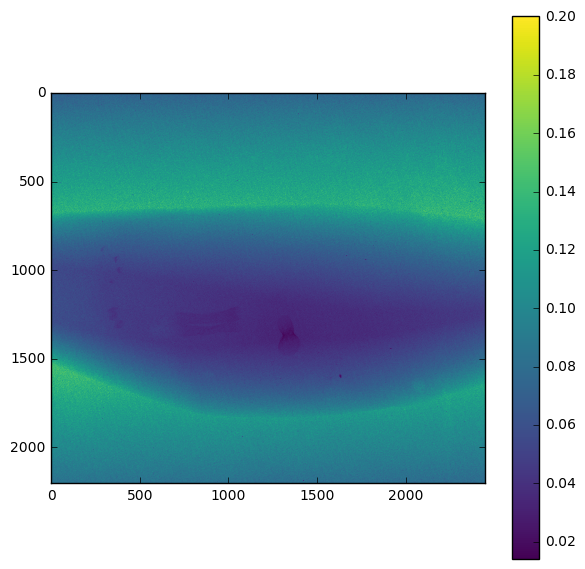

In [26]:
plt.figure(figsize=(7,7))
plt.imshow(uniq_data_images[1], vmax=0.2)
plt.colorbar()

In [27]:
#normalize data frames and calculate sinograms
empty_masked[empty_masked <= 0] = 1e-9

for di in range(uniq_data_images.shape[0]):
    t = uniq_data_images[di]
    t[t<0] = 1e-9
    t=t/empty_masked
    t[t>1] = 1
    t[t<1e-8] = 1e-8
    uniq_data_images[di] = t

del empty_masked

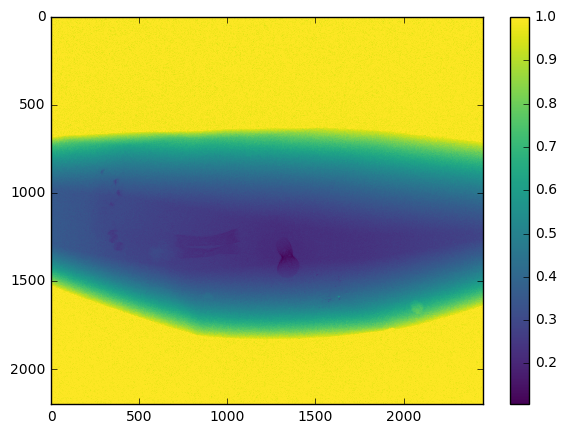

In [28]:
plt.figure(figsize=(7,5))
plt.imshow(uniq_data_images[1])
plt.colorbar()

In [29]:
sinogram, _ = load_create_mm(os.path.join(tmp_dir, 'sinogram.tmp'), shape=uniq_data_images.shape,
                         dtype='float32') 
ne.evaluate('-log(uniq_data_images)', out=sinogram);

Loading existing file: /diskmnt/fast/makov/robotom/6953bebf-4c50-4da1-8fa5-a6987a6ca36c/sinogram.tmp


In [30]:
del uniq_data_images

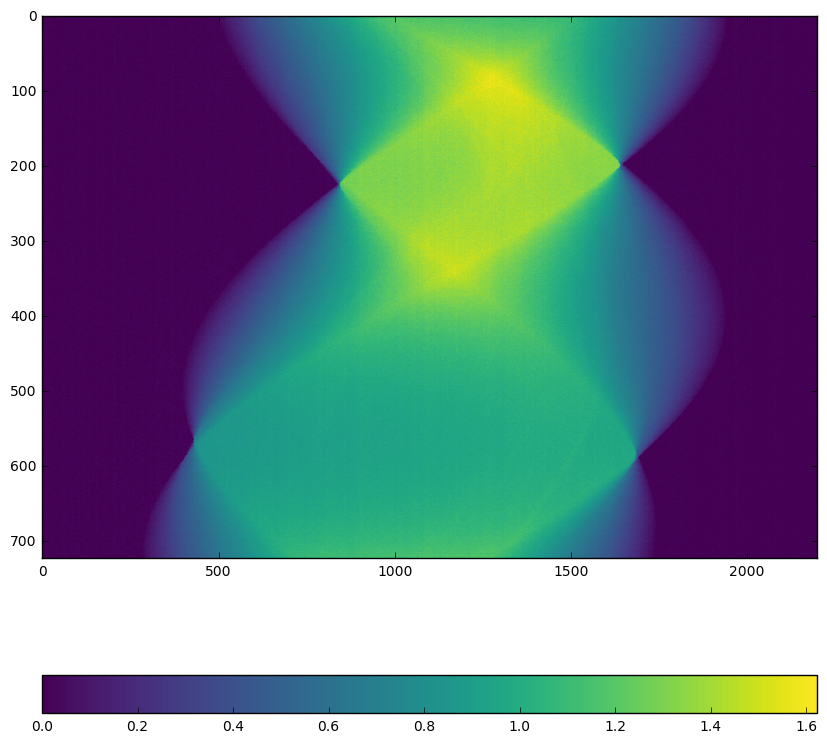

In [31]:
tmp_sinogram = sinogram[np.argsort(uniq_angles),:,sinogram.shape[-1]/2 ]

plt.figure(figsize=(10,10))
plt.imshow(tmp_sinogram, cmap=plt.cm.viridis)
plt.axis('tight')
plt.colorbar(orientation='horizontal')

In [32]:
# seraching detector rotation angle
zero_angle = np.min(uniq_angles)
position_0 = np.argwhere(np.isclose(uniq_angles, zero_angle, atol=0.05))[0][0]
print uniq_angles[position_0], position_0

position_180 = np.argwhere(np.isclose(uniq_angles, 180+zero_angle, atol=0.05))[0][0]
print uniq_angles[position_180], position_180

def cv_rotate(x, angle):
    """
    Rotate square array using OpenCV2 around center of the array
    :param x: 2d numpy array
    :param angle: angle in degrees
    :return: rotated array
    """
    x_center = tuple(
        np.array((x.shape[1], x.shape[0]), dtype='float32') / 2.0 - 0.5)
    rot_mat = cv2.getRotationMatrix2D(x_center, angle, 1.0)
    xro = cv2.warpAffine(
        x, rot_mat, (x.shape[1], x.shape[0]), flags=cv2.INTER_LINEAR)
    return xro


data_0 = np.rot90(sinogram[position_0]).copy()
data_180 = np.rot90(sinogram[position_180]).copy()

0.0 3
180.0 71


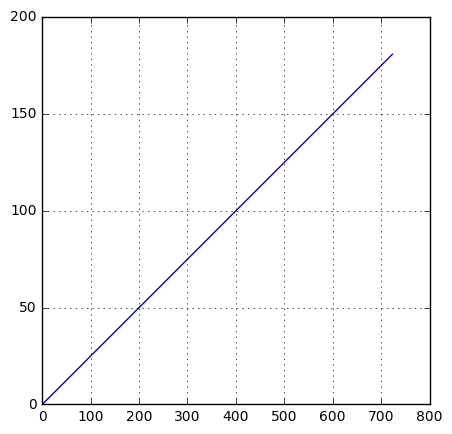

In [33]:
plt.figure(figsize=(5,5))
plt.plot(sorted(uniq_angles))
plt.grid(True)
plt.show()

In [34]:
from scipy.optimize import minimize
def f(x):
    alfa= x[0]
    shift = int(x[1])
    if shift >= 0:
        t = enp.fliplr(cv_rotate(data_180[:,shift:],alfa))-cv_rotate(data_0[:,shift:],alfa)
    else:
        t = np.fliplr(cv_rotate(data_180[:,:shift],alfa))-cv_rotate(data_0[:,shift],alfa)
        
    res = np.sum(t*t)/np.prod(t.shape)
    return res

def corr(x):
    alfa= x[0]*10.
    shift = int(x[1])
    if shift >= 0:
        t_180 = data_180[:,shift:]
        t_0 = data_0[:,shift:]
    else:
        t_180 = data_180[:,:shift]
        t_0 = data_0[:,:shift]
    
    
#     t_mask = np.zeros_like(t_0)
#     shape_min = np.min(t_mask.shape)
#     r_mask = shape_min//2
#     X,Y = np.meshgrid(np.arange(t_mask.shape[1])-t_mask.shape[1]//2,
#                       np.arange(t_mask.shape[0])-t_mask.shape[0]//2)
#     t_mask = X**2+Y**2<r_mask**2    
    
    tt_180 = np.fliplr(cv_rotate(t_180,alfa))
    tt_180 = cv2.medianBlur(tt_180,5) #*t_mask
    tt_0 = cv_rotate(t_0,alfa)
    tt_0 = cv2.medianBlur(tt_0,5) #*t_mask
    res = -np.correlate(tt_0.flat,tt_180.flat)
#     TODO: add mask support 
#     res = -np.sum(tt_0*tt_180)/np.sqrt(np.sum(tt_0**2)*np.sum(tt_180**2))*np.prod(tt_0.shape) #*np.prod(t_mask.shape)
    return res

x0 = [0.1,-355]
res= minimize(corr, x0, method='Nelder-Mead')
print res

 final_simplex: (array([[ -2.36252785e-03,   3.15930147e+01],
       [ -2.36252591e-03,   3.15930656e+01],
       [ -2.36251491e-03,   3.15930211e+01]]), array([-2189203.75, -2189203.75, -2189203.75]))
           fun: -2189203.75
       message: 'Optimization terminated successfully.'
          nfev: 137
           nit: 60
        status: 0
       success: True
             x: array([ -2.36252785e-03,   3.15930147e+01])


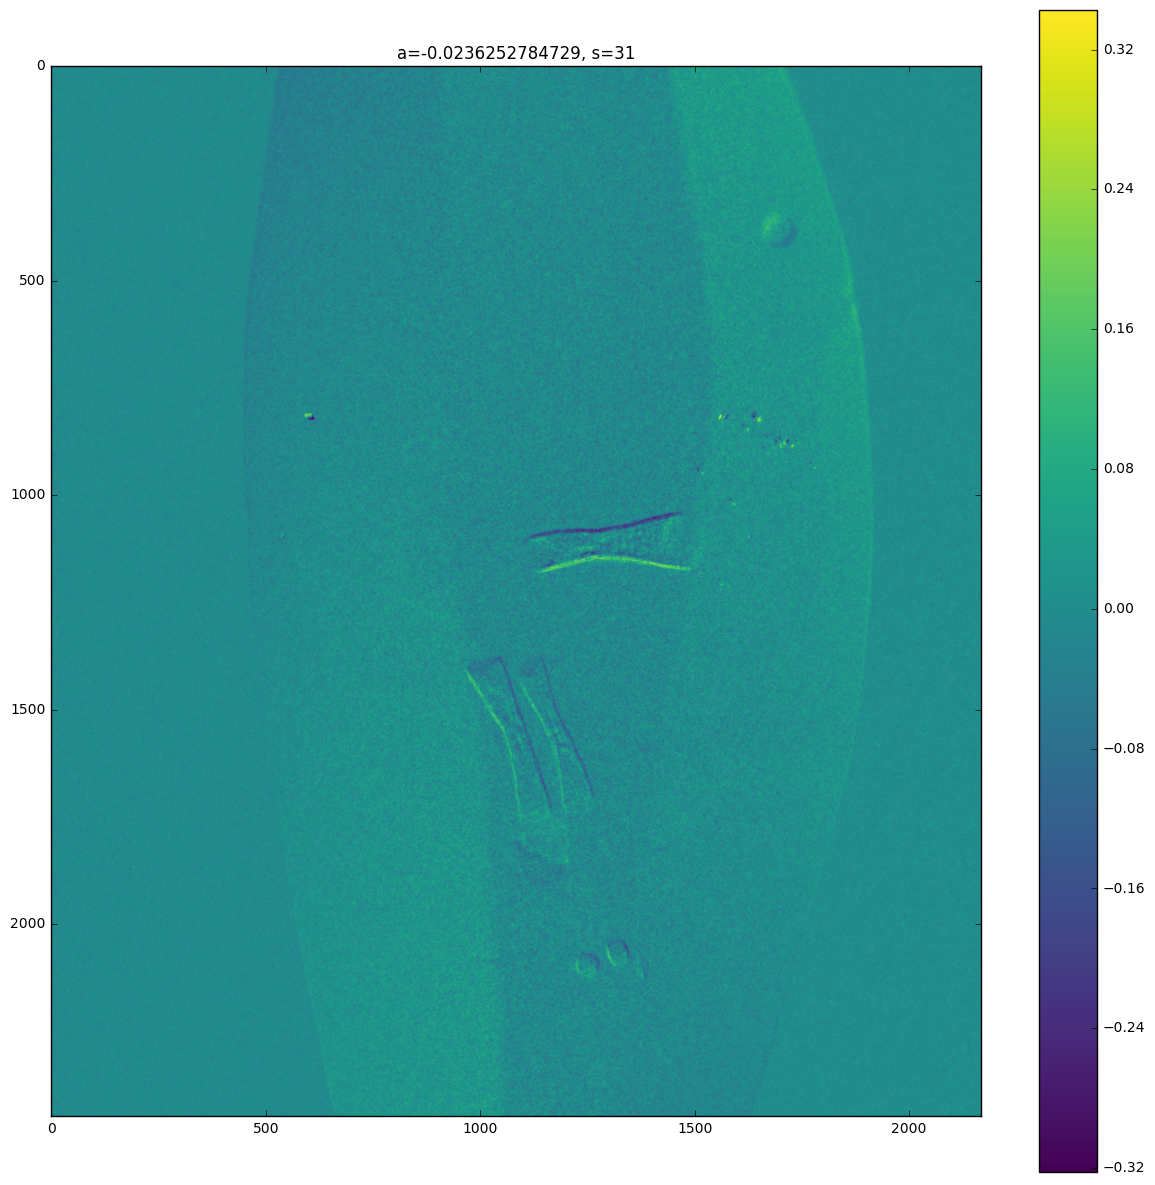

In [35]:
alfa, shift = res.x[0]*10., int(res.x[1])

if shift >= 0:
    t_180 = data_180[:,shift:]
    t_0 = data_0[:,shift:]
else:
    t_180 = data_180[:,:shift]
    t_0 = data_0[:,:shift]
    
tt_180 = np.fliplr(cv_rotate(t_180,alfa))
tt_0 = cv_rotate(t_0,alfa)
    
plt.figure(figsize=(15,15))
plt.imshow(tt_180-tt_0, cmap=plt.cm.viridis)
plt.title('a={}, s={}'.format(alfa,shift))
plt.colorbar()
plt.show()


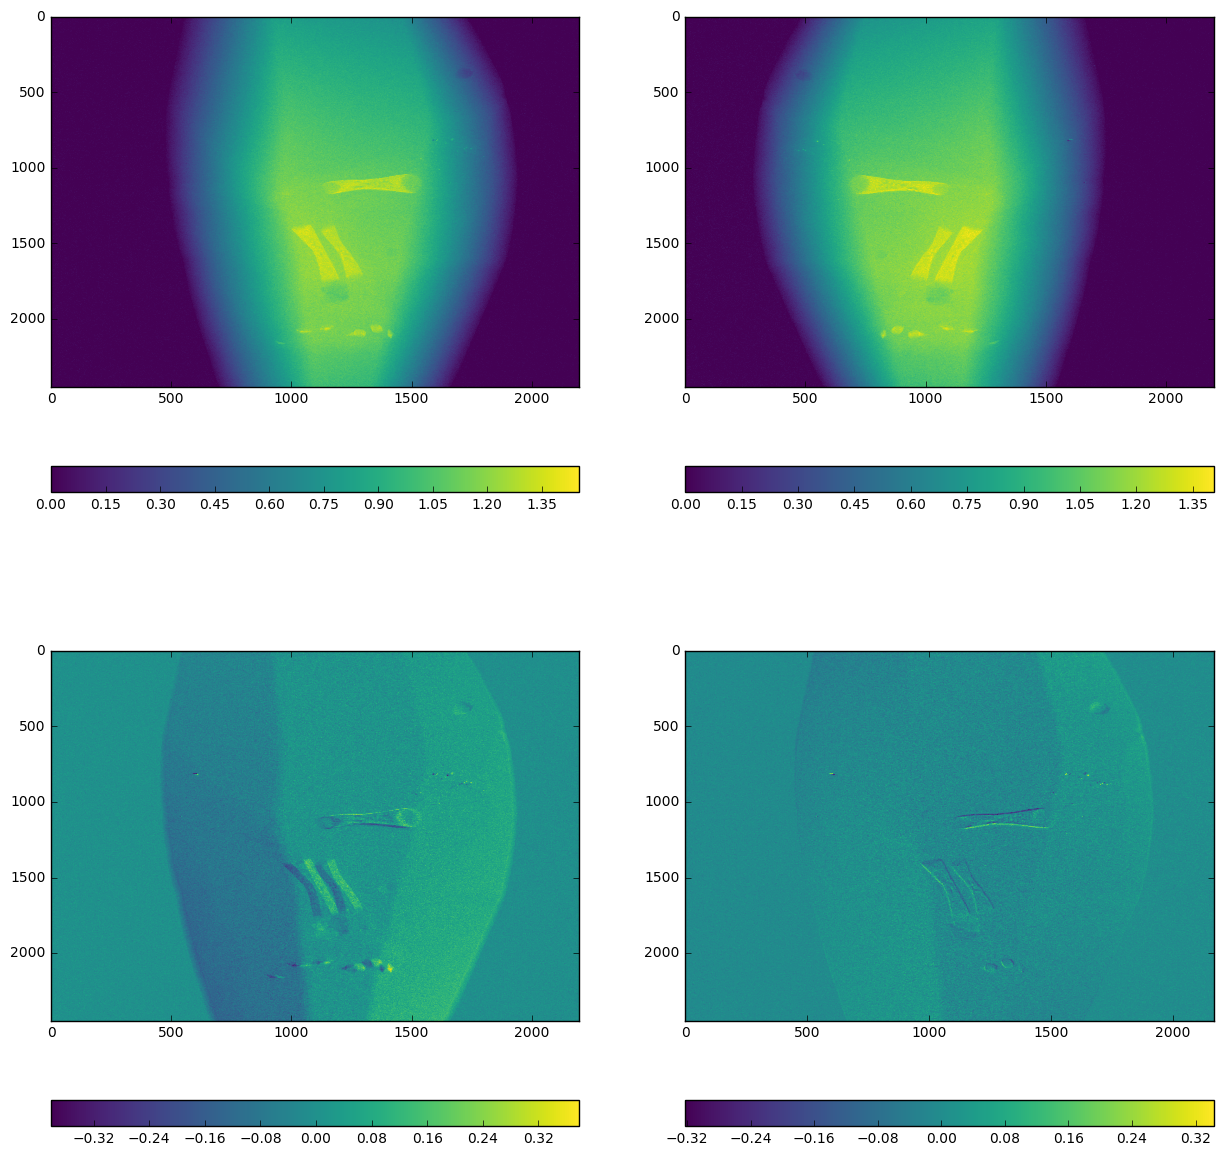

In [36]:
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(data_0,cmap=plt.cm.viridis)
plt.axis('tight')
plt.colorbar(orientation='horizontal')
plt.subplot(222)
plt.imshow(data_180,cmap=plt.cm.viridis)
plt.axis('tight')
plt.colorbar(orientation='horizontal')
plt.subplot(223)
plt.imshow(data_0 - np.fliplr(data_180),cmap=plt.cm.viridis)
plt.axis('tight')
plt.colorbar(orientation='horizontal')
plt.subplot(224)
# alfa = 0.1
# shift = -77
plt.imshow(tt_180-tt_0, cmap=plt.cm.viridis)
plt.axis('tight')
plt.colorbar(orientation='horizontal')

In [37]:
sinogram_fixed, _ = load_create_mm(os.path.join(tmp_dir,'sinogram_fixed.tmp'),
                                shape=(sinogram.shape[0], sinogram.shape[1]-abs(shift),sinogram.shape[2]),
                                dtype='float32')

#fix axis tlit
for i in range(sinogram.shape[0]):
    if shift >= 0:
        t = cv_rotate(sinogram[i,shift:],alfa)
    else:
        t = cv_rotate(sinogram[i,:shift],alfa)
    sinogram_fixed[i] = t
del sinogram

Loading existing file: /diskmnt/fast/makov/robotom/6953bebf-4c50-4da1-8fa5-a6987a6ca36c/sinogram_fixed.tmp


In [38]:
s1 = np.require(sinogram_fixed[...,sinogram_fixed.shape[-1]/2],
                dtype=np.float32, requirements=['C'])

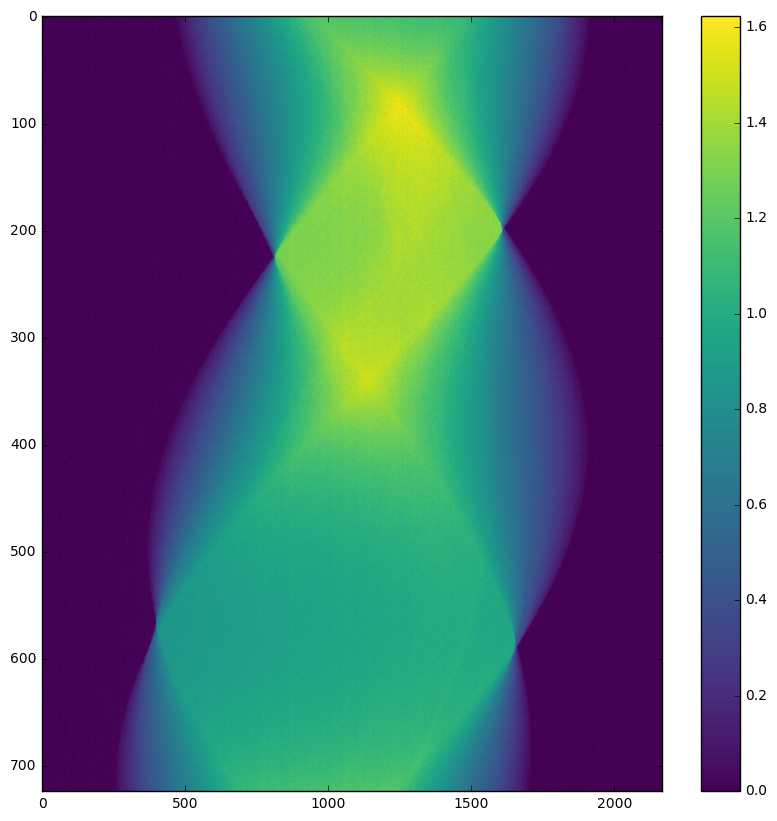

In [39]:
plt.figure(figsize=(10,10))
plt.imshow(s1[np.argsort(uniq_angles)], cmap=plt.cm.viridis)
plt.axis('tight')
plt.colorbar()
plt.show()

In [85]:
del sinogram_fixed

NameError: name 'sinogram_fixed' is not defined

In [91]:
del data_0, data_180 ,tmp_sinogram, uniq_angles

In [93]:
del empty_image, data_indexes, mask, t_0, t_180, zero_angle

In [14]:
uniq_angles, _ = load_create_mm(os.path.join(tmp_dir,'uniq_angles.tmp'),
                             shape= None,
                             dtype='float32')
s1, _ = load_create_mm(os.path.join(tmp_dir,'sinogram_fixed.tmp'),
                                shape= None,
                                dtype='float32')

rec_vol, _ = load_create_mm(os.path.join(tmp_dir,'rec.tmp'),
               dtype=np.float32,
               shape = (s1.shape[-1],s1.shape[1],s1.shape[1]))



(array(724, dtype=uint16),)
Loading existing file: /diskmnt/fast/makov/robotom/6953bebf-4c50-4da1-8fa5-a6987a6ca36c/uniq_angles.tmp
(724, 2168, 2449)
Loading existing file: /diskmnt/fast/makov/robotom/6953bebf-4c50-4da1-8fa5-a6987a6ca36c/sinogram_fixed.tmp
Loading existing file: /diskmnt/fast/makov/robotom/6953bebf-4c50-4da1-8fa5-a6987a6ca36c/rec.tmp


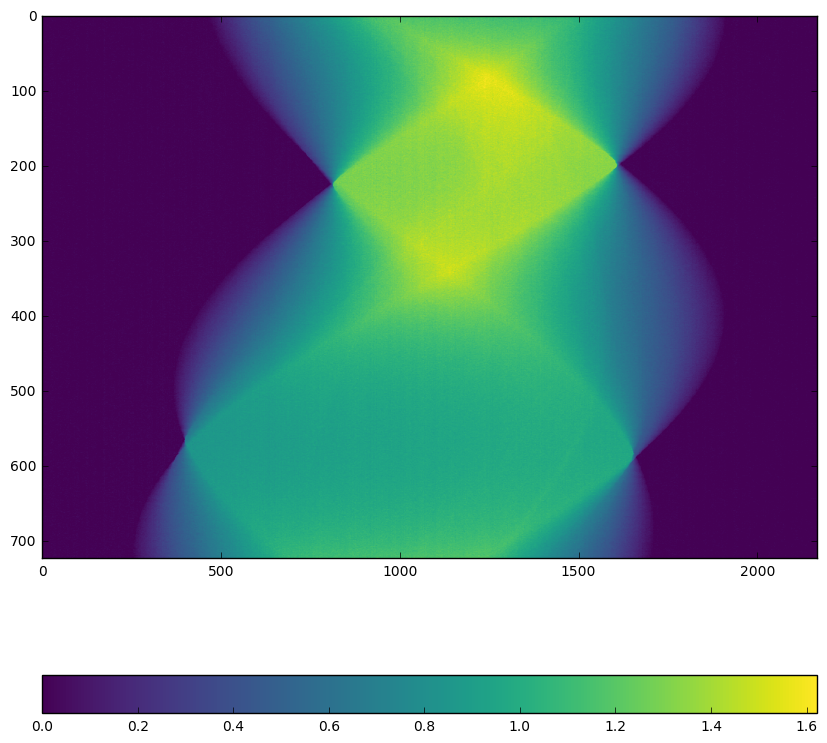

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(s1[np.argsort(uniq_angles),:,s1.shape[-1]/2], cmap=plt.cm.viridis)
plt.colorbar(orientation='horizontal')
plt.axis('tight')
plt.show()

In [16]:
def astra_tomo2d_parallel(sinogram, angles):
    astra.astra.set_gpu_index([1,])
    angles = angles.astype('float64')
    detector_size = sinogram.shape[1]
    

    rec_size = detector_size
    vol_geom = astra.create_vol_geom(rec_size, rec_size)
    proj_geom = astra.create_proj_geom('parallel', 1.0, detector_size, angles)


    sinogram_id = astra.data2d.create('-sino', proj_geom, data=sinogram)
    # Create a data object for the reconstruction
    rec_id = astra.data2d.create('-vol', vol_geom)
#     proj_id = astra.create_projector('strip', proj_geom, vol_geom) # for CPU reconstruction only
    # Set up the parameters for a reconstruction algorithm using the GPU
    cfg = astra.astra_dict('CGLS_CUDA')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id
#     cfg['ProjectorId'] = proj_id # for CPU reconstruction only
    cfg['option'] = {}
    cfg['option']['MinConstraint'] = -0.01
    # cfg['option']['MaxConstraint'] = 5

    # Available algorithms:
    # SIRT_CUDA, SART_CUDA, EM_CUDA, FBP_CUDA (see the FBP sample)

    # Create the algorithm object from the configuration structure
    
    alg_id = astra.algorithm.create(cfg)
    
    # Run 150 iterations of the algorithm
    astra.algorithm.run(alg_id, 30)
    # Get the result
    rec = astra.data2d.get(rec_id)
    
    # Clean up. Note that GPU memory is tied up in the algorithm object,
    # and main RAM in the data objects.
    astra.algorithm.delete(alg_id)
    astra.data2d.delete(rec_id)
    astra.data2d.delete(sinogram_id)
    astra.clear()
    return rec

#BROKEN
def astra_tomo3d_parallel(sinogram, angles, rec_vol, slice_start, slice_stop):
    astra.astra.set_gpu_index([1,])
    angles = angles.astype('float64')
    detector_size = sinogram.shape[1]
#         slices_number = sinogram.shape[0]
    slices_number = slice_stop - slice_start
        
    rec_size = detector_size
    vol_geom = astra.create_vol_geom(rec_size, rec_size, slices_number)
    proj_geom = astra.create_proj_geom('parallel3d', 1.0, 1.0,  slices_number, detector_size, angles)


    sinogram_id = astra.data3d.create('-sino', proj_geom, np.rollaxis(sinogram,-1)[slice_start:slice_stop])
    # Create a data object for the reconstruction
#     rec_id = astra.data3d.link('-vol', vol_geom, rec_vol[slice_start:slice_stop])
    rec_id = astra.data3d.create('-vol', vol_geom)
    # Set up the parameters for a reconstruction algorithm using the GPU
    cfg = astra.astra_dict('CGLS3D_CUDA')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id
#     cfg['ProjectorId'] = proj_id # for CPU reconstruction only
    cfg['option'] = {}
    #cfg['option']['MinConstraint'] = 0
    cfg['option']['MinConstraint'] = -0.01

    # Available algorithms:
    # SIRT_CUDA, SART_CUDA, EM_CUDA, FBP_CUDA (see the FBP sample)

    # Create the algorithm object from the configuration structure
    alg_id = astra.algorithm.create(cfg)
#     astra.data3d.info()
    # Run 150 iterations of the algorithm
    astra.algorithm.run(alg_id, 30)
    
    # Get the result
    rec = astra.data3d.get(rec_id)

    # Clean up. Note that GPU memory is tied up in the algorithm object,
    # and main RAM in the data objects.
    astra.algorithm.delete(alg_id)
    astra.data3d.delete(rec_id)
    astra.data3d.delete(sinogram_id)
    astra.clear()
    return rec

In [ ]:
t = time.time()
print s1.shape
step = 50
angles =np.array(uniq_angles)*np.pi/180
# for i in log_progress(range(1500, 1700, step)):
for i in log_progress(range(0, s1.shape[-1], step)):
    slice_start= i 
    slice_stop= min(i+step, s1.shape[-1])
    rec_vol[slice_start:slice_stop] = astra_tomo3d_parallel(s1, angles, rec_vol,
                                       slice_start=slice_start, slice_stop=slice_stop
                                  )
print(time.time()-t)

(724, 2168, 2449)
id  init  description
-----------------------------------------
1 	v     2168x724x50 sinogram data 	
2 	v     2168x2168x50 volume data 	
-----------------------------------------

id  init  description
-----------------------------------------
4 	v     2168x724x50 sinogram data 	
5 	v     2168x2168x50 volume data 	
-----------------------------------------

id  init  description
-----------------------------------------
7 	v     2168x724x50 sinogram data 	
8 	v     2168x2168x50 volume data 	
-----------------------------------------

id  init  description
-----------------------------------------
10 	v     2168x724x50 sinogram data 	
11 	v     2168x2168x50 volume data 	
-----------------------------------------

id  init  description
-----------------------------------------
13 	v     2168x724x50 sinogram data 	
14 	v     2168x2168x50 volume data 	
-----------------------------------------

id  init  description
-----------------------------------------
16 	v     2168

In [22]:
rec_vol.shape

(2449, 2168, 2168)

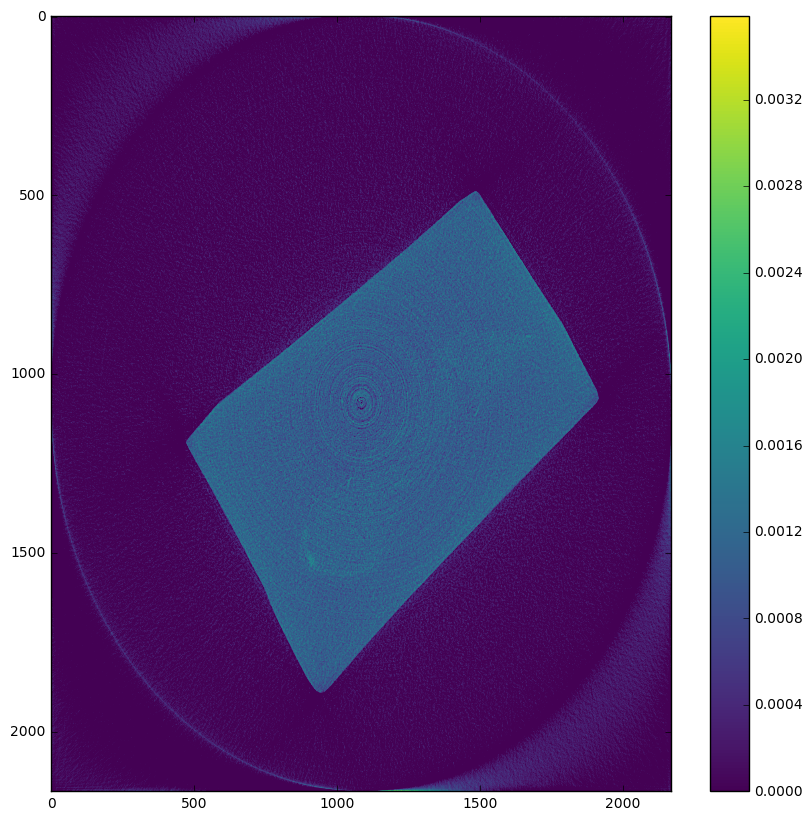

In [23]:
plt.figure(figsize=(10,10))
plt.imshow(rec_vol[int(rec_vol.shape[0]/2)], cmap=plt.cm.viridis, vmin=0)
plt.axis('tight')
plt.colorbar()
plt.show()

In [25]:
rec_vol_filtered, _ = load_create_mm(os.path.join(tmp_dir,'rec_filtered.tmp'),
               dtype=np.float32,
               shape = rec_vol.shape)

Loading existing file: /diskmnt/fast/makov/robotom/6953bebf-4c50-4da1-8fa5-a6987a6ca36c/rec_filtered.tmp


In [26]:
t = time.time()
print rec_vol.shape
step = 200
angles =np.array(uniq_angles)*np.pi/180
# for i in log_progress(range(1500, 1700, step)):
for i in log_progress(range(0, rec_vol.shape[0], step)):
    slice_start= i 
    slice_stop= min(i+step, s1.shape[-1])
    rec_vol_filtered[slice_start:slice_stop] = remove_ring(
        rec_vol[slice_start:slice_stop],
        thresh=0.0005,  theta_min=90, rwidth=10)
print(time.time()-t)

(2449, 2168, 2168)
640.229835033


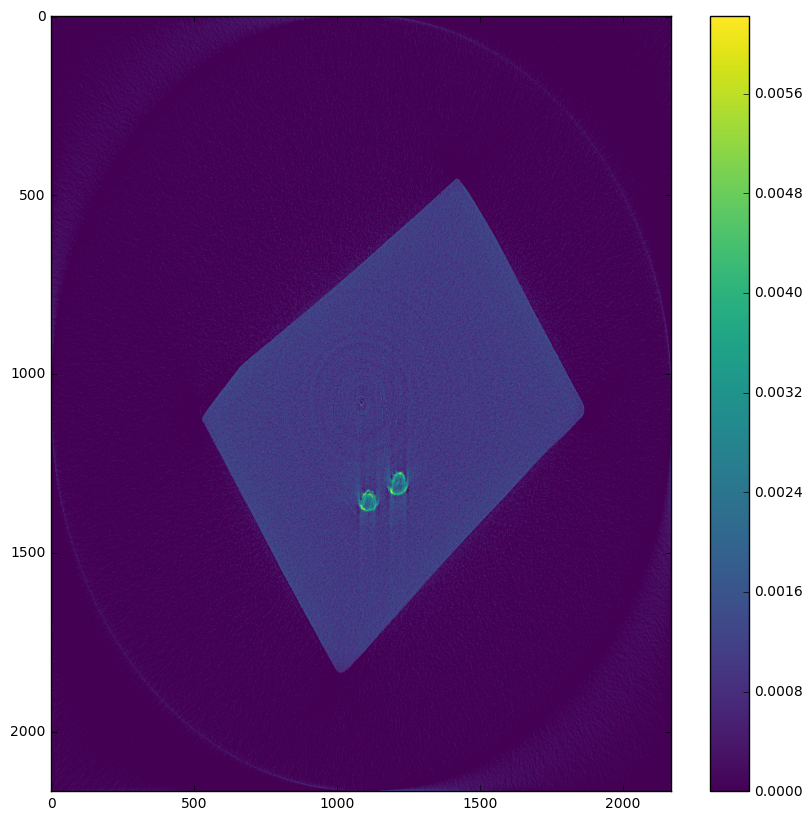

In [31]:
plt.figure(figsize=(10,10))
plt.imshow(rec_vol_filtered[int(rec_vol_filtered.shape[0]/2/1.5)], cmap=plt.cm.viridis, vmin=0)
plt.axis('tight')
plt.colorbar()
plt.show()

In [28]:
def save_amira(in_array, out_path, reshape=3):
    data_path = out_path
    with open(os.path.join(data_path, 'amira.raw'), 'wb') as amira_file:
        in_array[::reshape,::reshape,::reshape].tofile(amira_file)
        file_shape = in_array[::reshape,::reshape,::reshape].shape
        with open(os.path.join(data_path, 'tomo.hx'), 'w') as af:
                af.write('# Amira Script\n')
                af.write('remove -all\n')
                af.write(r'[ load -raw ${SCRIPTDIR}/amira.raw little xfastest float 1 '+
                         str(file_shape[1])+' '+str(file_shape[2])+' '+str(file_shape[0])+
                         ' 0 '+str(file_shape[1]-1)+' 0 '+str(file_shape[2]-1)+' 0 '+str(file_shape[0]-1)+
                         ' ] setLabel tomo.raw\n')


In [29]:
save_amira(rec_vol_filtered, tmp_dir)

In [ ]:
# angles = np.array(uniq_angles)*np.pi/180
# for slice_numb in log_progress(range(s1.shape[-1])):
#     rec_vol[slice_numb] = astra_tomo2d_parallel(s1[...,slice_numb], angles)

In [ ]:
# %timeit rec_slice = astra_tomo2d_parallel(s1[...,1600], uniq_angles*np.pi/180)

In [ ]:
# rec_slice = astra_tomo2d_parallel(s1[...,1550], uniq_angles*np.pi/180)
# plt.figure(figsize=(10,10))
# plt.imshow(rec_slice, cmap=plt.cm.viridis, vmin=0)
# plt.axis('tight')
# plt.colorbar()
# plt.show()

In [116]:
ss=np.array(7)

In [117]:
ss.ndim

0